# Study of Efficient Trading with Price Impact by Tianyu Sun

Brokmann, Xavier and Gonon, Lukas and He, Guangyi and Itkin, David and Muhle-Karbe, Johannes, Efficient Trading with Price Impact (November 08, 2024). Available at SSRN: https://ssrn.com/abstract=5014119 or http://dx.doi.org/10.2139/ssrn.5014119

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.optimize import fsolve
from tensorflow.keras import layers, models

In [2]:
data = pd.read_csv('merged_data.csv')

In [3]:
dQ = data['Signed Volume'].values
data['ts_event'] = pd.to_datetime(data['ts_event'])
data['ts_event_seconds'] = (data['ts_event'] - data['ts_event'].iloc[0]).dt.total_seconds()
delta_t = data['ts_event_seconds'].diff().fillna(0).values

# 1. Construct and code the linear OW model and nonlinear AFS model, and visualize the distribution of price impact based on the given data.

In [4]:
# Parameters
beta = 0.2/3600
lambda_ow = 0.35
lambda_afs = 0.35
p = 0.99

In [5]:
def exponential_decay_kernel(delta_t, beta):
    return np.exp(-beta * delta_t)

def compute_Jn(dQ, delta_t, beta):
    time_steps = len(dQ)
    Jn = np.zeros(time_steps)
    for t in range(1, time_steps):
        decay_factor = exponential_decay_kernel(delta_t[t], beta)
        Jn[t] = decay_factor * (Jn[t-1] + dQ[t]) # Use (C.4) to calculate discounted quantity
    return Jn

def price_impact_OW(x, lambda_h):
    return lambda_h * x

def price_impact_AFS(x, lambda_afs, p):
    return lambda_afs * np.sign(x) * np.abs(x)**p

In [6]:
Jn = compute_Jn(dQ, delta_t, beta)
I_t_ow = price_impact_OW(Jn, lambda_ow)
I_t_afs = price_impact_AFS(Jn, lambda_afs, p)

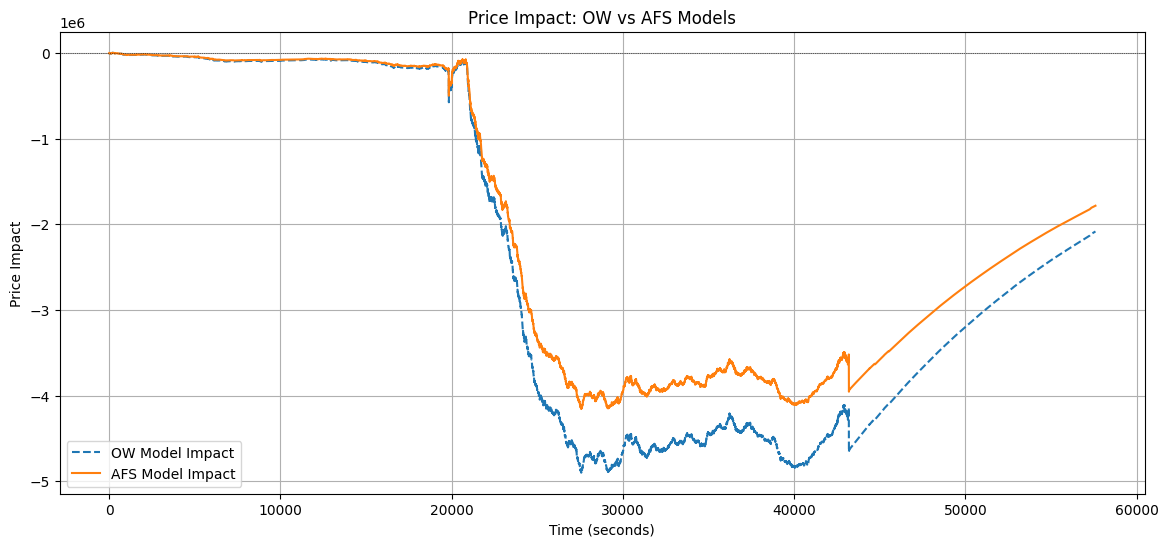

In [7]:
# Add impacts to the dataframe
data['I_t_ow'] = I_t_ow
data['I_t_afs'] = I_t_afs

# Visualize the impacts
plt.figure(figsize=(14, 6))
plt.plot(data['ts_event_seconds'], data['I_t_ow'], label='OW Model Impact', linestyle='--')
plt.plot(data['ts_event_seconds'], data['I_t_afs'], label='AFS Model Impact', linestyle='-')
plt.axhline(0, color='black', linewidth=0.5, linestyle=':')
plt.xlabel('Time (seconds)')
plt.ylabel('Price Impact')
plt.title('Price Impact: OW vs AFS Models')
plt.legend()
plt.grid()
plt.show()

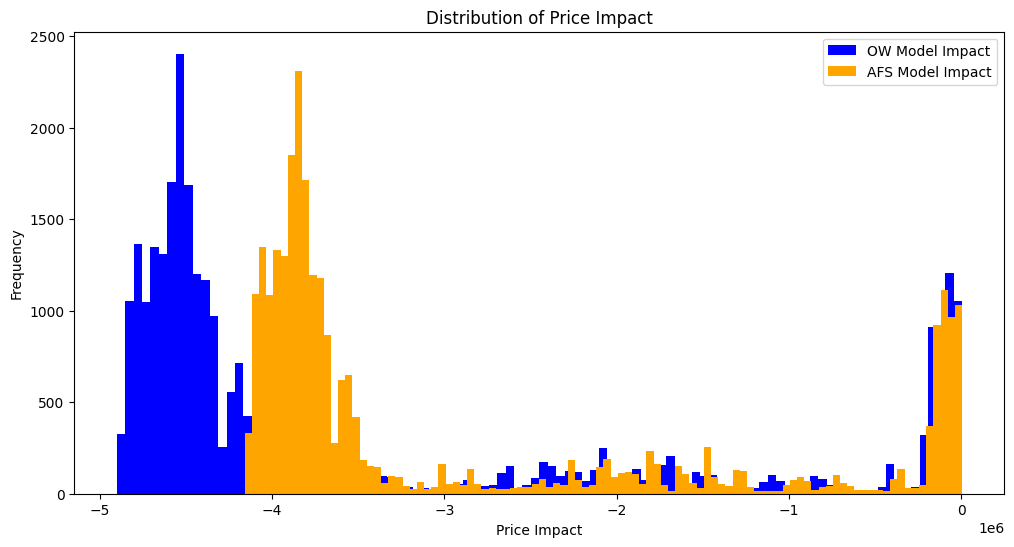

In [8]:
plt.figure(figsize=(12, 6))

# OW Model Impact Histogram
plt.hist(I_t_ow, bins=100, label="OW Model Impact", color="blue")

# AFS Model Impact Histogram
plt.hist(I_t_afs, bins=100, label="AFS Model Impact", color="orange")

plt.xlabel("Price Impact")
plt.ylabel("Frequency")
plt.title("Distribution of Price Impact")

plt.legend()
plt.show()

It can be observed from the distribution of OW linear model and AFS nonlinear model that the linear model has more impact than nonlinear model.

# 2. Implement and code the optimal strategy with Linear Impact and visualize the Sharpe Ratio plots in Section 6.2.

In [9]:
# Simulation parameters
alpha = 0.01
sigma = 0.02
phi = 0.139

In [10]:
def compute_Cf(alpha, phi, gamma, sigma, lambda_param, beta):
    return alpha * (1 + beta / phi) / (
        gamma * sigma**2 * (np.sqrt(1 + 2 * lambda_param * beta / (gamma * sigma**2)) + beta / phi)
    )

def compute_CJ(gamma, sigma, lambda_param, beta):
    return np.sqrt(1 + 2 * lambda_param * beta / (gamma * sigma**2)) - 1

def simulate_f(T, delta_t, phi):
    f = np.zeros(T)
    for t in range(1, T):
        decay = np.exp(-phi * delta_t[t])  # Decay factor
        noise_scale = np.sqrt(1 - np.exp(-2 * phi * delta_t[t]))  # Noise scale
        f[t] = decay * f[t-1] + noise_scale * np.random.normal() # Signal is generated using (C.6)
    return f

def compute_Q(f, dQ, delta_t, alpha, phi, gamma, sigma, lambda_ow, beta):
    Cf = compute_Cf(alpha, phi, gamma, sigma, lambda_ow, beta)
    CJ = compute_CJ(gamma, sigma, lambda_ow, beta)
    Jn = compute_Jn(dQ, delta_t, beta)
    Q = Cf * f - CJ * Jn
    return Q

def compute_R2(alpha, sigma, phi, beta, lambda_param, gamma):
    term1 = (alpha**2 * sigma**2) / ((gamma * sigma**2)**2)
    term2 = (1 + beta / phi)**2
    term3 = np.sqrt(1 + 2 * lambda_param * beta / (gamma * sigma**2))
    term4 = (term3 + beta / phi)**3
    return term1 * term2 * ((beta / phi) * term3 + 1) / (term3 * term4)

def compute_pnl(alpha, gamma, sigma, beta, phi, lam):
    xi = np.sqrt(gamma * sigma**2 * (gamma * sigma**2 + 2 * lam * beta))

    numerator = alpha**2 * gamma * sigma**2 * (beta + phi)**2
    denominator = (beta * gamma * sigma**2 + xi * phi)**2

    pnl = numerator / denominator
    return pnl

When $h^n(x)=\lambda x$ and $K^n(t)=e^{-\beta t}$, then the PnL in (5.1) simply becomes $\dfrac{\alpha^2 \gamma \sigma^2 (\beta + \phi)^2}{\left( \beta \gamma \sigma^2 + \xi \phi \right)^2}$

In [11]:
def gamma_equation(gamma, alpha, sigma, phi, beta, lambda_param, R2_target):
    R2_computed = compute_R2(alpha, sigma, phi, beta, lambda_param, gamma)
    return R2_computed - R2_target


# Solve for gamma (risk tolerance)
gamma_initial_guess = 0.1
R2_target = 0.1
gamma = fsolve(gamma_equation, gamma_initial_guess, args=(alpha, sigma, phi, beta, lambda_ow, R2_target))[0]
R2 = compute_R2(alpha, sigma, phi, beta, lambda_ow, gamma)
print(f"Computed R2: {R2}") # Sanity check

Computed R2: 0.10000000000000042


In [12]:
# Simulate trading signals
np.random.seed(42)
f = simulate_f(len(data), delta_t, phi)

In [13]:
# gamma
# compute_R2(alpha, sigma, phi, beta, lambda_ow, gamma)

In [14]:
# Construct portfolio
Q = compute_Q(f, dQ, delta_t, alpha, phi, gamma, sigma, lambda_ow, beta)

In [15]:
# Calculate Sharpe Ratio
Sharpe_Ratio = compute_pnl(alpha, gamma, sigma, beta, phi, lambda_ow) / np.sqrt(R2_target)

In [16]:
Sharpe_Ratio

0.49999989947705437

In [17]:
Sharpe_Ratio_list = []
beta_ratios = np.linspace(0.01/3600, 0.1/3600, 10)

for beta in beta_ratios:
    gamma_initial_guess = 0.1
    R2_target = 1
    gamma = fsolve(gamma_equation, gamma_initial_guess, args=(alpha, sigma, phi, beta, lambda_ow, R2_target))[0]
    print(f"Computed R2: {compute_R2(alpha, sigma, phi, beta, lambda_ow, gamma)}")
    Sharpe_Ratio = compute_pnl(alpha, gamma, sigma, beta, phi, lambda_ow) / np.sqrt(R2_target)
    Sharpe_Ratio_list.append(Sharpe_Ratio)

Computed R2: 1.0000000000000273
Computed R2: 1.0000000000000022
Computed R2: 1.0000000000000007
Computed R2: 0.9999999999999998
Computed R2: 1.0
Computed R2: 1.0
Computed R2: 1.0000000000001168
Computed R2: 1.0000000000000162
Computed R2: 1.000000000000002
Computed R2: 1.0


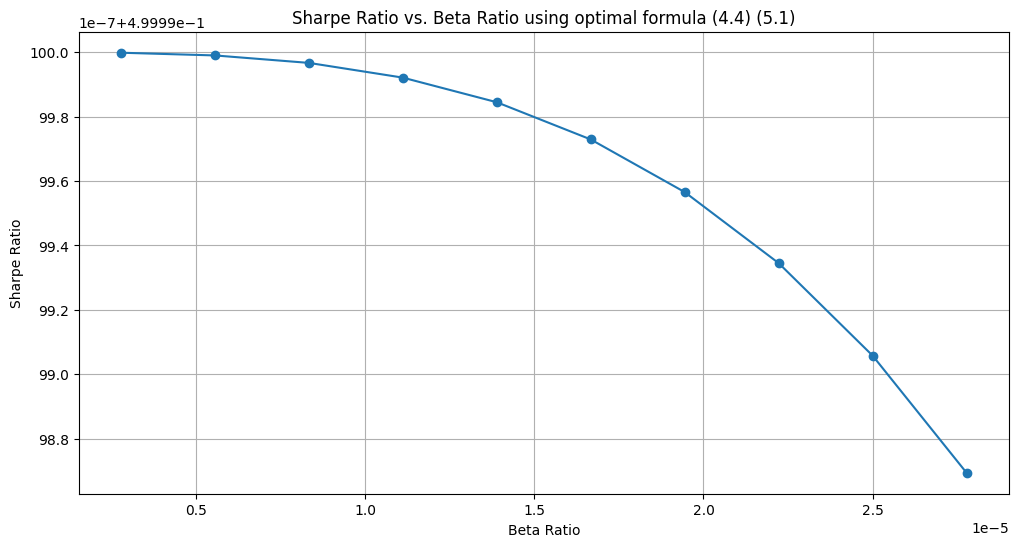

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(beta_ratios, Sharpe_Ratio_list, marker='o')
plt.xlabel('Beta Ratio')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio vs. Beta Ratio using optimal formula (4.4) (5.1)')
plt.grid()
plt.show()

The formula didn't give me a good result. So I compute Sharpe ratio by constructing a portfolio and study the effect of Beta and Lambda

In [19]:
Sharpe_Ratio_list_betas = []
betas = np.linspace(0.01, 0.5, 10)
lambda_ow = 0.45
gamma_initial_guess = 0.1
R2_target = 1

for beta in betas:
    gamma = fsolve(gamma_equation, gamma_initial_guess, args=(alpha, sigma, phi, beta/3600, lambda_ow, R2_target))[0]
    print(f"Computed R2: {compute_R2(alpha, sigma, phi, beta/3600, lambda_ow, gamma)}")
    Q = compute_Q(f, dQ, delta_t, alpha, phi, gamma, sigma, lambda_ow, beta/3600)
    PnL_M = Q[:] * data['mid_price'][:]
    Sharpe_Ratio = np.mean(PnL_M) / np.std(PnL_M)
    Sharpe_Ratio_list_betas.append(Sharpe_Ratio)

Computed R2: 1.0000000000000127
Computed R2: 1.0000000000000087
Computed R2: 0.9999999999999999
Computed R2: 0.9999999999999999
Computed R2: 1.000000000000001
Computed R2: 0.9999999999999994
Computed R2: 1.0000000000000007
Computed R2: 1.0000000000000004
Computed R2: 1.000000000000001
Computed R2: 0.9999999999999997


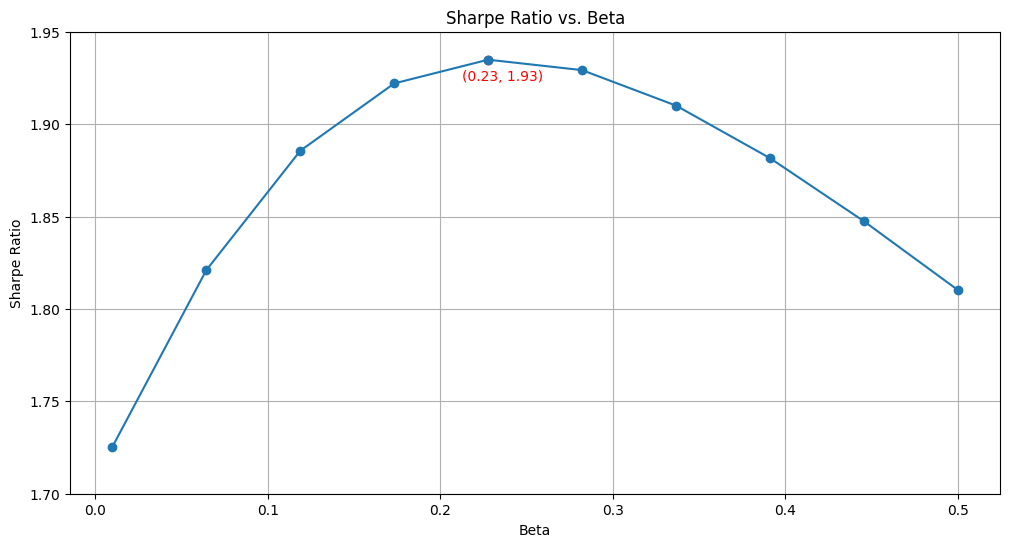

In [20]:
max_sharpe_ratio = max(Sharpe_Ratio_list_betas)
max_sharpe_index = Sharpe_Ratio_list_betas.index(max_sharpe_ratio)
max_beta = betas[max_sharpe_index]
plt.figure(figsize=(12, 6))
plt.plot(betas, Sharpe_Ratio_list_betas, marker='o')
plt.xlabel('Beta')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio vs. Beta')
plt.scatter(max_beta, max_sharpe_ratio, color='red', label='Max Sharpe Ratio')
plt.annotate(f'({max_beta:.2f}, {max_sharpe_ratio:.2f})',
             (max_beta, max_sharpe_ratio),
             textcoords="offset points", xytext=(10, -15), ha='center',
             color='red', fontsize=10)
plt.ylim(1.70, 1.95)
plt.grid()
plt.show()

In [21]:
Sharpe_Ratio_list_lambdas = []
lambdas = np.linspace(0.35, 0.45, 10)
beta = 0.23/3600
gamma_initial_guess = 0.1
R2_target = 1

for lam in lambdas:
    gamma = fsolve(gamma_equation, gamma_initial_guess, args=(alpha, sigma, phi, beta, lam, R2_target))[0]
    print(f"Computed R2: {compute_R2(alpha, sigma, phi, beta, lam, gamma)}")
    Q = compute_Q(f, dQ, delta_t, alpha, phi, gamma, sigma, lam, beta)
    PnL_M = Q[:] * data['mid_price'][:]
    Sharpe_Ratio = np.mean(PnL_M) / np.std(PnL_M)
    Sharpe_Ratio_list_lambdas.append(Sharpe_Ratio)

Computed R2: 0.9999999999999994
Computed R2: 1.0000000000000002
Computed R2: 1.0000000000000002
Computed R2: 1.0000000000000007
Computed R2: 1.0000000000000002
Computed R2: 1.000000000000047
Computed R2: 1.0000000000000184
Computed R2: 1.0000000000000073
Computed R2: 1.0000000000000033
Computed R2: 1.0000000000000004


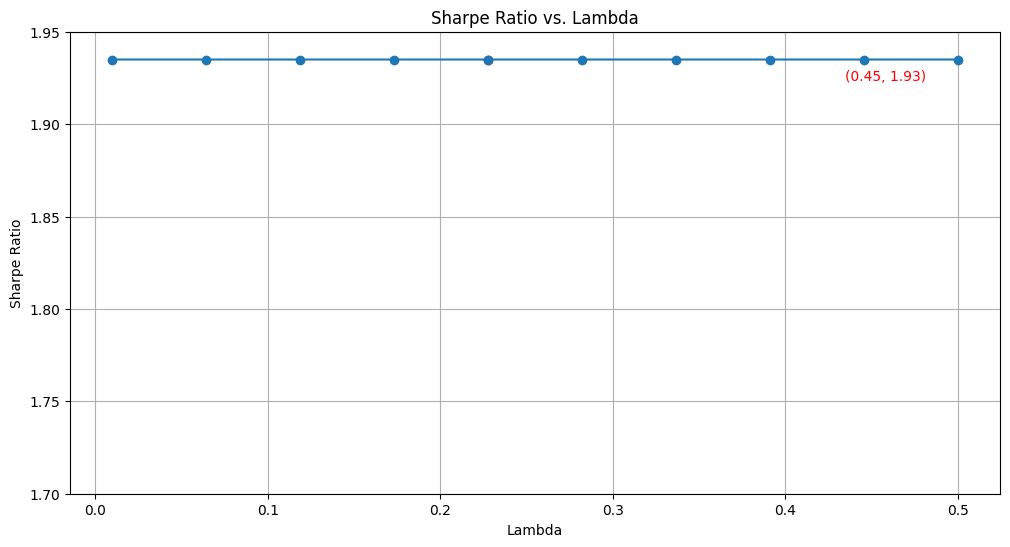

In [22]:
max_sharpe_ratio = max(Sharpe_Ratio_list_lambdas)
max_sharpe_index = Sharpe_Ratio_list_lambdas.index(max_sharpe_ratio)
max_lambda = lambdas[max_sharpe_index]
plt.figure(figsize=(12, 6))
plt.plot(betas, Sharpe_Ratio_list_lambdas, marker='o')
plt.xlabel('Lambda')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio vs. Lambda')
plt.scatter(max_beta, max_sharpe_ratio, color='red', label='Max Sharpe Ratio')
plt.annotate(f'({max_lambda:.2f}, {max_sharpe_ratio:.2f})',
             (max_lambda, max_sharpe_ratio),
             textcoords="offset points", xytext=(10, -15), ha='center',
             color='red', fontsize=10)
plt.ylim(1.70, 1.95)
plt.grid()
plt.show()

I tried using the optimal PnL and R^2 in (4.4) and (5.1). But the result is not concave and I cannot find a maximum. I haven't check their calculation yet to make sure the formula is correct.

Then I use the actual data to calculate PnL and construct portfolio and calculate Sharpe ratio from the price data. I am able to obtain result similar to those shown in the paper. But the impact of lambda and beta are reversed, and if I change the R^2 risk level, the difference in optimal sharpe ratio is not very obvious.

One obstacle I faced is to find risk tolerence coefficient $\gamma$ from $R^2$. The author claim that it is easy to find $\gamma$ at a given daily risk $DR=R$ using (4.4). But I fould solving the equation analytically is impossible. And it is also difficult to solve it numerical using fsolve, especially if the initial value is not set very well.

# 3. Implement and code the Deep Learning Algorithm in for discrete setting in Appendix C.2 and visualize the training loss for different network structures in Appendix C.2.

In [23]:
np.random.seed(42)
tf.random.set_seed(42)

# Constants
alpha_hat = 1.67e-4
gamma_sigma2 = 0.1
lambda_hat = 0.0035
beta = 2
p = 0.5
delta_t = 0.01
N = 5120
batch_size = 1024
epochs = 50
phi = 0.139

def simulate_f(batch_size, T, delta_t, phi):
    f = np.zeros((batch_size, T))
    for t in range(1, T):
        decay = np.exp(-phi * delta_t)
        noise_scale = np.sqrt(1 - np.exp(-2 * phi * delta_t))
        f[:, t] = decay * f[:, t-1] + noise_scale * np.random.normal(size=batch_size)
    return f

fn_minus1 = simulate_f(batch_size, N, delta_t, phi)

fn_minus1 = tf.convert_to_tensor(fn_minus1, dtype=tf.float32)


def train_model(model, initial_learning_rate, epochs):
    losses = []
    for epoch in range(epochs):
        # Adjust learning rate
        if epoch < 30:
            lr = initial_learning_rate
        else:
            factor = ((epoch - 30) // 5) + 1
            lr = initial_learning_rate * (0.25) ** factor

        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

        with tf.GradientTape() as tape:
            total_objective = 0.0

            J0n_minus1 = tf.zeros((batch_size,))

            for n in range(N):
                fn_minus1_n = fn_minus1[:, n]
                x = tf.stack([fn_minus1_n, J0n_minus1], axis=1)

                Qn = model(x)

                Qn = tf.squeeze(Qn, axis=1)

                exp_beta_dt = tf.exp(-beta * delta_t)
                J0n = exp_beta_dt * J0n_minus1 - (1.0 - exp_beta_dt) * Qn

                Jn = Qn + J0n

                # Compute objective_terms
                term1 = alpha_hat * Qn * fn_minus1_n
                term2 = (gamma_sigma2 / 2.0) * tf.square(Qn)
                term3 = lambda_hat * beta * tf.pow(tf.abs(Jn), p+1)

                objective_terms = term1 - term2 - term3

                total_objective += tf.reduce_sum(objective_terms)

                J0n_minus1 = J0n

            average_objective = total_objective / (batch_size * N)

            loss = -average_objective

        gradients = tape.gradient(loss, model.trainable_variables)

        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        losses.append(loss.numpy())

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.numpy()}, Learning Rate: {lr}")
    return losses



In [24]:
class NLTransformation(tf.keras.layers.Layer):
    def __init__(self, p=0.5, B=10.0, **kwargs):
        super().__init__(**kwargs)
        self.p = p
        self.B = B

        # Precompute constants a and b to make sure NL is continuous and differentiable at B
        self.a = (1 / p) * B ** ((1 / p) - 1)
        self.b = (1 - (1 / p)) * B ** (1 / p)

    def call(self, inputs):
        x = inputs
        sign_x = tf.sign(x)
        abs_x = tf.abs(x)

        nonlinear_part = sign_x * tf.pow(abs_x, 1 / self.p)

        linear_part = self.a * x + sign_x * self.b

        output = tf.where(abs_x < self.B, nonlinear_part, linear_part)
        return output


# Define nonlinear model
p = 0.5
B = 10.0

NetPower = tf.keras.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(128),
    layers.ReLU(),
    layers.Dense(32),
    layers.ReLU(),
    layers.Dense(8),
    layers.ReLU(),
    layers.Dense(1),
    NLTransformation(p=p, B=B)
])


NetSimple = tf.keras.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(128),
    layers.ReLU(),
    layers.Dense(32),
    layers.ReLU(),
    layers.Dense(8),
    layers.ReLU(),
    layers.Dense(1)
])


NetLinear = tf.keras.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(1)
])

In [25]:
# Train linear model
print("\nTraining Linear Model")
NetLinear_losses = train_model(NetLinear, initial_learning_rate=1e-2, epochs=epochs)


Training Linear Model
Epoch 1/50, Loss: 0.003001681761816144, Learning Rate: 0.01


KeyboardInterrupt: 

In [ ]:
# Train nonlinear model
print("Training Nonlinear Model")
NetSimple_losses = train_model(NetSimple, initial_learning_rate=1e-4, epochs=epochs)

In [ ]:
# Plot losses
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), NetLinear_losses, label="NetLinear")
plt.plot(range(epochs), NetSimple_losses, label="NetSimple")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Comparison Between Nonlinear and Linear Models")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("Training Nonlinear Model")
nonlinear_losses = train_model(NetPower, initial_learning_rate=1e-4, epochs=epochs)

I don't have enough computational power to train all three models, and they took very long time to train on CPU.

A technique I could have implemented is nonzero initialization of f, J0n_minus1, and Q as mentioned in the paper. The training should be done without the data and the signals f can be generated by Monte Carlo, which is what I did. But to fully replicate the result found in the paper, some parameters need to be known like all the greek letters. I tried my best to apply all the techniques found in the paper like nonlinear transformation (C.20) and linear decay learning rate.